<a href="https://colab.research.google.com/github/thuh66271-arch/THUC-HANH/blob/main/BTKTM_MH_UD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bước 1: Cài đặt và import thư viện...

Bước 2: Bắt đầu đo lường hiệu năng và bảo mật...
  -> Đang đo lường: AES
  -> Đang đo lường: DES
  -> Đang đo lường: Blowfish
  -> Đang đo lường: RC5 (Sim)

Đo lường hoàn tất.

--- BẢNG KẾT QUẢ TÓM TẮT ---
           Encryption Time (s)  Decryption Time (s)  Throughput Enc (MB/s)  \
AES                   0.003426             0.005796            1459.298866   
DES                   0.076295             0.079787              65.535486   
Blowfish              0.040573             0.040448             123.233762   
RC5 (Sim)             0.041915             0.041120             119.288033   

           Throughput Dec (MB/s)  Memory Overhead (MB)  Avalanche Effect (%)  \
AES                   862.708626                   0.0             30.588235   
DES                    62.666934                   0.0             23.437500   
Blowfish              123.615847                   0.0             24.218750   
RC5 (Sim)             121.594656            

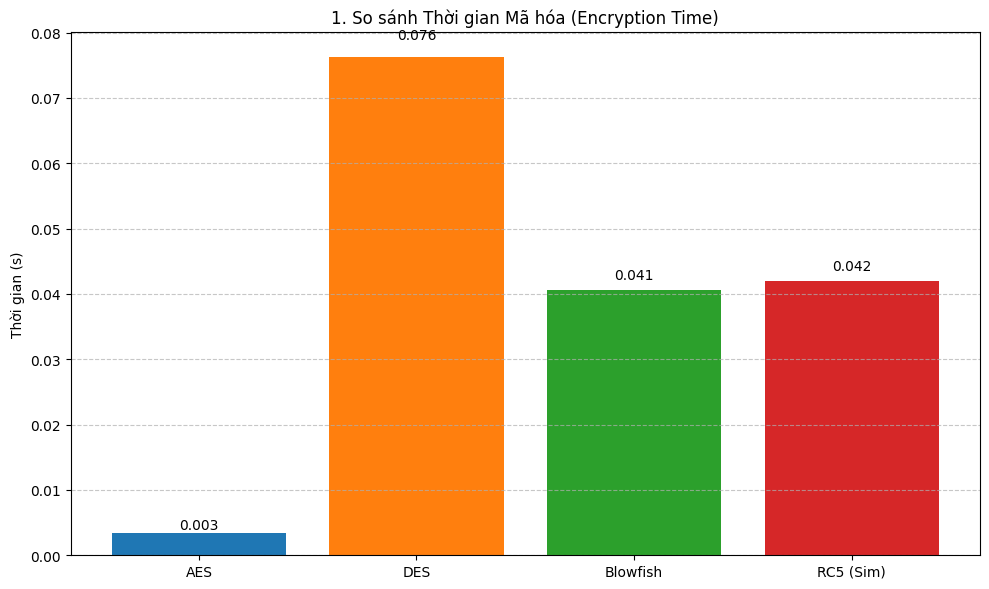

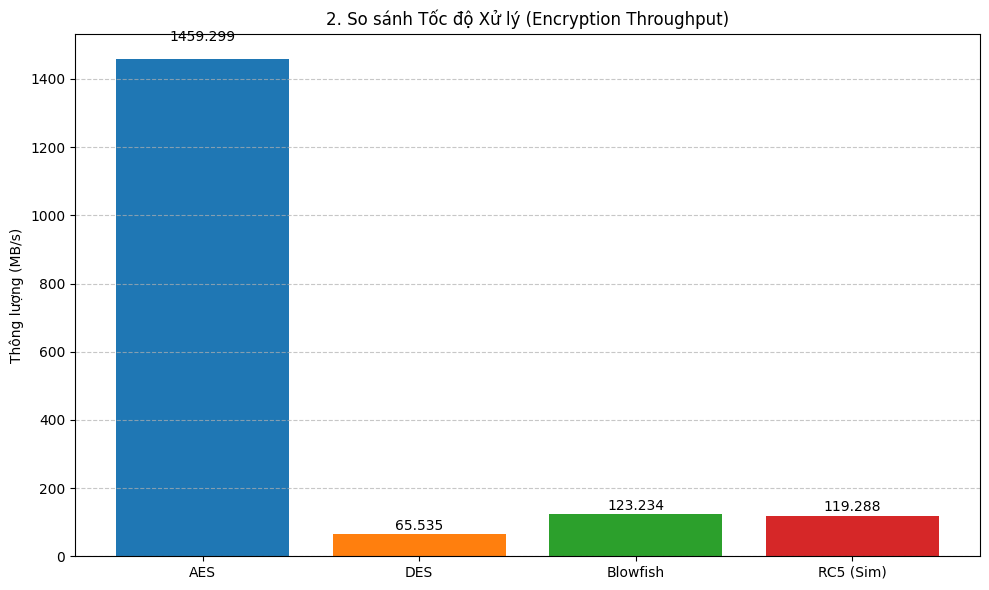

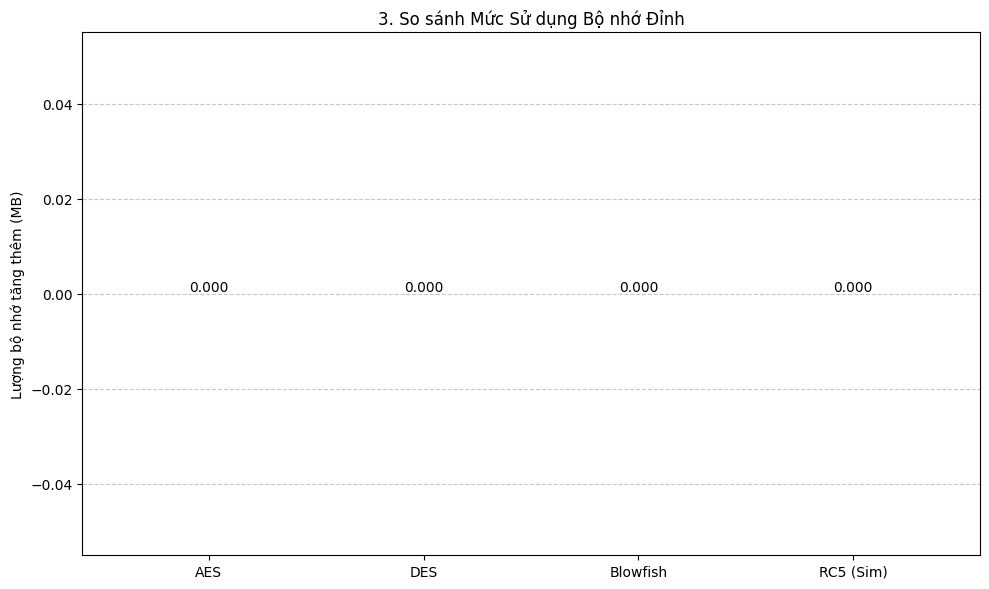

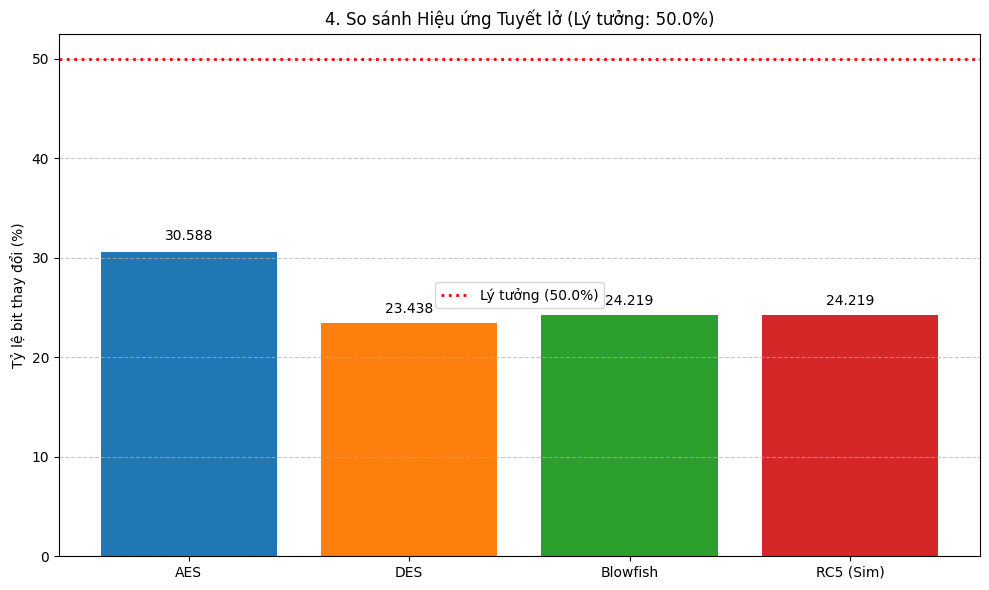

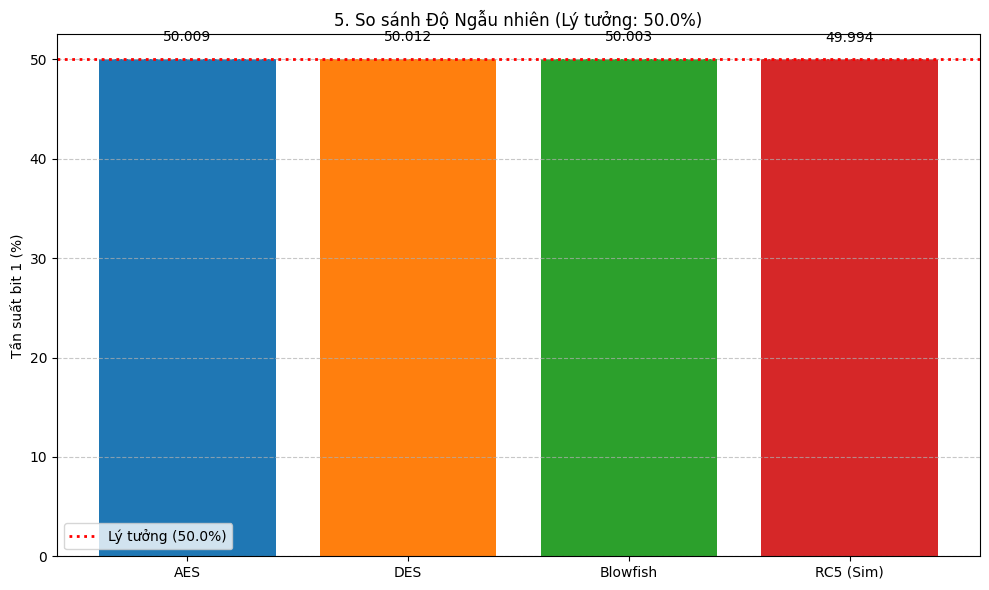


Đã hoàn thành phần lập trình và trực quan hóa kết quả. Bạn có thể dựa vào các biểu đồ và bảng dữ liệu để đưa ra nhận xét, đánh giá khách quan về ưu nhược điểm của từng thuật toán.


In [5]:
# BƯỚC 1: THIẾT LẬP VÀ CÀI ĐẶT THƯ VIỆN

print("Bước 1: Cài đặt và import thư viện...")
!pip install pycryptodome psutil -qq
import time
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import psutil # Để đo lường bộ nhớ
from Crypto.Cipher import AES, DES, Blowfish
from Crypto.Util.Padding import pad, unpad
from random import randbytes


# BƯỚC 2: CẤU HÌNH HỆ THỐNG VÀ HẰNG SỐ

# Lưu ý: Các thông số cho RC5 được mô phỏng bằng Blowfish hoặc cấu hình tương đương (64-bit block).
KEY_SIZES = {
    "AES": 16,     # 128 bit
    "DES": 8,      # 64 bit
    "Blowfish": 16,
    "RC5 (Sim)": 16 # Mô phỏng
}

BLOCK_SIZES = {
    "AES": 16,
    "DES": 8,
    "Blowfish": 8,
    "RC5 (Sim)": 8 # Mô phỏng
}

ALGORITHMS = ["AES", "DES", "Blowfish", "RC5 (Sim)"]
DATA_SIZE = 1024 * 1024 * 5  # Kích thước dữ liệu mẫu: 5 MB
data_to_encrypt = randbytes(DATA_SIZE)
RESULTS = {alg: {} for alg in ALGORITHMS}



# BƯỚC 3: CÁC HÀM HỖ TRỢ


def get_cipher(algorithm_name, key_size, block_size):
    """Khởi tạo đối tượng Cipher với Key ngẫu nhiên và chế độ ECB."""
    # Sử dụng chế độ ECB để đơn giản hóa việc đo lường hiệu năng và Avalanche Effect.
    key = randbytes(key_size)
    if algorithm_name == "AES":
        return AES.new(key, AES.MODE_ECB), key
    elif algorithm_name == "DES":
        return DES.new(key, DES.MODE_ECB), key
    elif algorithm_name == "Blowfish":
        return Blowfish.new(key, Blowfish.MODE_ECB), key
    elif algorithm_name == "RC5 (Sim)":
        # Sử dụng Blowfish làm đại diện mô phỏng cho thuật toán khối 64-bit.
        return Blowfish.new(key, Blowfish.MODE_ECB), key
    return None, None

def get_current_rss_mb():
    """Trả về mức sử dụng bộ nhớ RSS hiện tại của tiến trình (MB)."""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 * 1024)


# BƯỚC 4: NHÓM TIÊU CHÍ HIỆU NĂNG


def measure_performance(algorithm_name, data):
    """Đo thời gian, thông lượng và mức sử dụng bộ nhớ."""
    key_size = KEY_SIZES[algorithm_name]
    block_size = BLOCK_SIZES[algorithm_name]

    # 1. Chuẩn bị
    cipher_enc, key = get_cipher(algorithm_name, key_size, block_size)
    padded_data = pad(data, block_size)

    # 2. Đo lường MÃ HÓA
    mem_before_enc = get_current_rss_mb()
    start_time_enc = time.time()
    ciphertext = cipher_enc.encrypt(padded_data)
    encryption_time = time.time() - start_time_enc
    mem_after_enc = get_current_rss_mb()

    # 3. Đo lường GIẢI MÃ
    # Cần đảm bảo cùng Key. Khởi tạo lại đối tượng cipher với cùng khóa.
    if algorithm_name == "AES":
        cipher_dec = AES.new(key, AES.MODE_ECB)
    elif algorithm_name == "DES":
        cipher_dec = DES.new(key, DES.MODE_ECB)
    elif algorithm_name == "Blowfish":
        cipher_dec = Blowfish.new(key, Blowfish.MODE_ECB)
    elif algorithm_name == "RC5 (Sim)":
        cipher_dec = Blowfish.new(key, Blowfish.MODE_ECB)
    else:
        raise ValueError(f"Unknown algorithm: {algorithm_name}")

    mem_before_dec = get_current_rss_mb()
    start_time_dec = time.time()
    decrypted_data = unpad(cipher_dec.decrypt(ciphertext), block_size)
    decryption_time = time.time() - start_time_dec
    mem_after_dec = get_current_rss_mb()

    # 4. Tính toán kết quả
    data_size_mb = len(padded_data) / (1024 * 1024)

    throughput_enc = data_size_mb / encryption_time
    throughput_dec = data_size_mb / decryption_time

    # Lưu kết quả
    RESULTS[algorithm_name]['Encryption Time (s)'] = encryption_time
    RESULTS[algorithm_name]['Decryption Time (s)'] = decryption_time
    RESULTS[algorithm_name]['Throughput Enc (MB/s)'] = throughput_enc
    RESULTS[algorithm_name]['Throughput Dec (MB/s)'] = throughput_dec
    # Lượng bộ nhớ tăng thêm trong quá trình xử lý (ước tính)
    RESULTS[algorithm_name]['Memory Overhead (MB)'] = max(0, mem_after_enc - mem_before_enc)

    return ciphertext


# BƯỚC 5: NHÓM TIÊU CHÍ BẢO MẬT


def calculate_avalanche(algorithm_name, original_data):
    """Đo lường Hiệu ứng Tuyết lở (thay đổi 1 bit đầu tiên của bản rõ)."""
    key_size = KEY_SIZES[algorithm_name]
    block_size = BLOCK_SIZES[algorithm_name]

    # Chỉ xét trên 1 khối dữ liệu
    data_block = original_data[:block_size]

    # Tạo bản rõ biến đổi (chỉ thay đổi 1 bit)
    modified_data_block = bytearray(data_block)
    modified_data_block[0] ^= 0b00000001 # Đảo bit LSB của byte đầu tiên

    # Mã hóa cả hai khối
    cipher, _ = get_cipher(algorithm_name, key_size, block_size)

    padded_original = pad(data_block, block_size)
    original_ciphertext = cipher.encrypt(padded_original)

    padded_modified = pad(modified_data_block, block_size)
    modified_ciphertext = cipher.encrypt(padded_modified)

    # Chuyển đổi sang chuỗi bit và tính sự khác biệt
    original_bits = bin(int.from_bytes(original_ciphertext, byteorder='big'))[2:]
    modified_bits = bin(int.from_bytes(modified_ciphertext, byteorder='big'))[2:]

    # Đảm bảo cùng độ dài để so sánh
    max_len = max(len(original_bits), len(modified_bits))
    original_bits = original_bits.zfill(max_len)
    modified_bits = modified_bits.zfill(max_len)

    # Đếm số bit khác nhau (Hamming Distance)
    diff_bits = sum(c1 != c2 for c1, c2 in zip(original_bits, modified_bits))
    total_bits = max_len

    avalanche_score_pt = diff_bits / total_bits

    RESULTS[algorithm_name]['Avalanche Effect (%)'] = avalanche_score_pt * 100
    return avalanche_score_pt

def monobit_test(ciphertext, algorithm_name):
    """Đánh giá Độ ngẫu nhiên bằng Monobit Test (Kiểm tra Tần suất bit 1)."""
    bits = bin(int.from_bytes(ciphertext, byteorder='big'))[2:]
    total_bits = len(bits)
    count_ones = bits.count('1')

    # Lý tưởng là 50%
    percentage_ones = (count_ones / total_bits) * 100

    RESULTS[algorithm_name]['Ciphertext Randomness (% 1s)'] = percentage_ones
    return percentage_ones


# BƯỚC 6: HÀM VẼ BIỂU ĐỒ


def plot_results(metric_name, ylabel, title, data_key, ideal_value=None):
    """Vẽ biểu đồ so sánh cho một tiêu chí."""
    algorithms = ALGORITHMS
    # Lấy giá trị từ DataFrame (được tạo ở BƯỚC 7)
    values = df[data_key]

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(algorithms, values,
                  color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Thêm đường giá trị lý tưởng nếu có
    if ideal_value is not None:
        ax.axhline(ideal_value, color='red', linestyle=':', linewidth=2, label=f'Lý tưởng ({ideal_value}%)')
        ax.legend()

    # Thêm giá trị lên trên mỗi cột
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.03 * yval,
                f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()


# BƯỚC 7: THỰC THI CHÍNH


print("\nBước 2: Bắt đầu đo lường hiệu năng và bảo mật...")
for alg in ALGORITHMS:
    print(f"  -> Đang đo lường: {alg}")
    ciphertext = measure_performance(alg, data_to_encrypt)
    calculate_avalanche(alg, data_to_encrypt)
    monobit_test(ciphertext, alg)

print("\nĐo lường hoàn tất.")

# Chuyển kết quả sang DataFrame để dễ nhìn
df = pd.DataFrame(RESULTS).T
print("\n--- BẢNG KẾT QUẢ TÓM TẮT ---")
print(df)


# BƯỚC 8: VẼ BIỂU ĐỒ


print("\nBước 3: Vẽ biểu đồ trực quan hóa...")

# 1. Hiệu năng (Thời gian Mã hóa) - Thấp hơn là tốt hơn
plot_results('Encryption Time', 'Thời gian (s)', '1. So sánh Thời gian Mã hóa (Encryption Time)', 'Encryption Time (s)')
#

# 2. Hiệu năng (Thông lượng) - Cao hơn là tốt hơn
plot_results('Throughput Enc', 'Thông lượng (MB/s)', '2. So sánh Tốc độ Xử lý (Encryption Throughput)', 'Throughput Enc (MB/s)')
#

# 3. Kỹ thuật triển khai (Sử dụng Bộ nhớ) - Thấp hơn là tốt hơn
plot_results('Memory Overhead', 'Lượng bộ nhớ tăng thêm (MB)', '3. So sánh Mức Sử dụng Bộ nhớ Đỉnh', 'Memory Overhead (MB)')

# 4. Bảo mật (Avalanche Effect) - Càng gần 50% càng tốt
plot_results('Avalanche Effect', 'Tỷ lệ bit thay đổi (%)', '4. So sánh Hiệu ứng Tuyết lở (Lý tưởng: 50.0%)', 'Avalanche Effect (%)', ideal_value=50.0)

# 5. Bảo mật (Độ ngẫu nhiên) - Càng gần 50% càng tốt
plot_results('Ciphertext Randomness', 'Tần suất bit 1 (%)', '5. So sánh Độ Ngẫu nhiên (Lý tưởng: 50.0%)', 'Ciphertext Randomness (% 1s)', ideal_value=50.0)

print("\nĐã hoàn thành phần lập trình và trực quan hóa kết quả. Bạn có thể dựa vào các biểu đồ và bảng dữ liệu để đưa ra nhận xét, đánh giá khách quan về ưu nhược điểm của từng thuật toán.")